In [4]:
pip install torch_geometric

  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

In [1]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
KEY_CONFIG = {
    "atoms": "elements", 
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}
ATOM_MAP = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}

In [3]:
class ReactionDataset(Dataset):
    def __init__(self, h5_path, limit=None, transform=None, pre_transform=None):
        super(ReactionDataset, self).__init__(None, transform, pre_transform)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            atoms = group[KEY_CONFIG["atoms"]][()]
            x_indices = [ATOM_MAP.get(int(a), 0) for a in atoms]
            x = F.one_hot(torch.tensor(x_indices, dtype=torch.long), num_classes=5).float()
            
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            y_delta = e_TS - e_R

            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)

            return Data(x=x, pos=pos_R, edge_index=edge_index, y_energy=y_delta, y_pos=pos_TS)

In [4]:
class DeepGCPLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(), 
            nn.Dropout(dropout), # Dropout 추가
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.update_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), 
            nn.Dropout(dropout), # Dropout 추가
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        message = self.message_mlp(edge_feat)
        
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, message)
        
        new_h = self.update_mlp(torch.cat([h, aggr_msg], dim=-1))
        return self.norm(h + new_h)

In [5]:
class DeepGCPNet(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(node_dim, hidden_dim)
        self.layers = nn.ModuleList([DeepGCPLayer(hidden_dim) for _ in range(num_layers)])
        
    def forward(self, x, pos, edge_index):
        h = self.embedding(x)
        for layer in self.layers:
            h = layer(h, pos, edge_index)
        return h

In [6]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [7]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1)
        )
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

In [8]:
class EdgeEnergyPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        
        # 1. Base Energy (Node)
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # 2. Barrier Cost (Edge)
        edge_input_dim = (hidden_dim * 2) + 1 + 1 + 1 
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, edge_index, pos, gate_score, pred_delta_D, batch):
        row, col = edge_index
        
        # A. Base Energy
        h_graph = global_add_pool(h, batch)
        base_energy = self.node_mlp(h_graph)
        
        # B. Edge Barrier Energy
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist, pred_delta_D, gate_score], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat)
        
        # 반응 중심(Gate)에 비례하여 에너지 합산
        edge_contrib = edge_contrib * gate_score
        
        edge_batch = batch[row]
        barrier_energy = global_add_pool(edge_contrib, edge_batch)
        
        return base_energy + barrier_energy

In [9]:
class MultiEnergyModel(nn.Module):
    def __init__(self, node_dim=5, hidden_dim=256, num_layers=4):
        super().__init__()
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = EdgeEnergyPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        # EdgeEnergyPredictor 호출 (인자 많음 주의)
        pred_delta_E3 = self.energy_predictor(
            h, data.edge_index, data.pos, gate_map, pred_delta_D, data.batch
        )
        
        return pred_delta_D, pred_delta_E3, gate_map

In [10]:
def train(h5_path, epochs=20, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    try:
        dataset = ReactionDataset(h5_path, limit=limit)
    except Exception as e:
        print(f"❌ Dataset Error: {e}"); return None, None, None

    # Normalization Stats
    print("Computing stats...")
    loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
    all_E = []
    HARTREE_TO_KCAL = 627.5
    for b in loader_stat:
        all_E.append(b.y_energy.view(-1, 3) * HARTREE_TO_KCAL)
    all_E = torch.cat(all_E, dim=0)
    y_mean = all_E.mean(dim=0).to(device)
    y_std = all_E.std(dim=0).to(device)
    print(f"Stats -> Mean: {y_mean.cpu().numpy()}, Std: {y_std.cpu().numpy()}")

    # DataLoader & Model
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = MultiEnergyModel(node_dim=5, hidden_dim=256, num_layers=4).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    
    print("\n[Start Final Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        total_gate_mean = 0 # Gating 모니터링용
        
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            pred_d, pred_e3, gate = model(batch)
            
            # Ground Truth
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            delta_d_target = dist_TS - dist_R
            
            # Normalization
            e_target_kcal = batch.y_energy.view(-1, 3) * HARTREE_TO_KCAL
            e_target_norm = (e_target_kcal - y_mean) / y_std
            
            # Loss Calculation (Huber)
            loss_struct = F.smooth_l1_loss(pred_d, delta_d_target)
            loss_energy = F.smooth_l1_loss(pred_e3, e_target_norm)
            loss_gate = F.binary_cross_entropy(gate, (torch.abs(delta_d_target)>0.1).float())
            
            total_loss = loss_struct + loss_energy + loss_gate
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            total_gate_mean += gate.mean().item()
            
            # 진행바에 Gating 상태 표시 (중요!)
            # Gate 값이 0.0이나 1.0에 고착되지 않고 0.1~0.2 사이인지 확인하세요.
            pbar.set_postfix({
                'Loss': f"{total_loss.item():.4f}", 
                'Gate': f"{gate.mean().item():.3f}" 
            })
            
            if epoch == epochs - 1:
                r = e_target_kcal.detach().cpu().numpy()
                p_norm = pred_e3.detach().cpu() * y_std.cpu() + y_mean.cpu()
                p = p_norm.numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])
                    
        avg_loss = epoch_loss / len(loader)
        avg_gate = total_gate_mean / len(loader)
        history['loss'].append(avg_loss)
        scheduler.step(avg_loss)
        
        print(f"  -> Avg Gate Score: {avg_gate:.4f}")

    return history, real_E3, pred_E3

📂 데이터 파일 경로 확인 중: C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code\RGD1_CHNO.h5
✅ 파일을 찾았습니다! 학습을 시작합니다...
Device: cpu
Computing stats...


C:\Users\yeseo\anaconda3\envs\mlchem\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Stats -> Mean: [69.403175 74.3915   72.29167 ], Std: [28.19911  26.560163 29.295467]

[Start Final Training]


Epoch 1/40: 100%|████████████████████████████████████████| 313/313 [33:44<00:00,  6.47s/batch, Loss=1.3937, Gate=0.532]


  -> Avg Gate Score: 0.4269


Epoch 2/40: 100%|████████████████████████████████████████| 313/313 [34:03<00:00,  6.53s/batch, Loss=1.1548, Gate=0.620]


  -> Avg Gate Score: 0.5953


Epoch 3/40: 100%|████████████████████████████████████████| 313/313 [33:33<00:00,  6.43s/batch, Loss=1.0332, Gate=0.643]


  -> Avg Gate Score: 0.5859


Epoch 4/40: 100%|████████████████████████████████████████| 313/313 [33:32<00:00,  6.43s/batch, Loss=1.3580, Gate=0.587]


  -> Avg Gate Score: 0.6006


Epoch 5/40: 100%|████████████████████████████████████████| 313/313 [33:15<00:00,  6.38s/batch, Loss=1.2186, Gate=0.631]


  -> Avg Gate Score: 0.6054


Epoch 6/40: 100%|████████████████████████████████████████| 313/313 [33:20<00:00,  6.39s/batch, Loss=1.1680, Gate=0.617]


  -> Avg Gate Score: 0.5938


Epoch 7/40: 100%|████████████████████████████████████████| 313/313 [33:08<00:00,  6.35s/batch, Loss=1.2709, Gate=0.623]


  -> Avg Gate Score: 0.6017


Epoch 8/40: 100%|████████████████████████████████████████| 313/313 [33:50<00:00,  6.49s/batch, Loss=1.2385, Gate=0.633]


  -> Avg Gate Score: 0.6075


Epoch 9/40: 100%|████████████████████████████████████████| 313/313 [33:04<00:00,  6.34s/batch, Loss=0.9062, Gate=0.682]


  -> Avg Gate Score: 0.6080


Epoch 10/40: 100%|███████████████████████████████████████| 313/313 [33:04<00:00,  6.34s/batch, Loss=1.0973, Gate=0.625]


  -> Avg Gate Score: 0.6064


Epoch 11/40: 100%|███████████████████████████████████████| 313/313 [33:28<00:00,  6.42s/batch, Loss=1.1709, Gate=0.570]


  -> Avg Gate Score: 0.6081


Epoch 12/40: 100%|███████████████████████████████████████| 313/313 [29:22<00:00,  5.63s/batch, Loss=1.4057, Gate=0.680]


  -> Avg Gate Score: 0.6165


Epoch 13/40: 100%|███████████████████████████████████████| 313/313 [33:05<00:00,  6.34s/batch, Loss=0.9428, Gate=0.616]


  -> Avg Gate Score: 0.6073


Epoch 14/40: 100%|███████████████████████████████████████| 313/313 [33:27<00:00,  6.41s/batch, Loss=1.1722, Gate=0.621]


  -> Avg Gate Score: 0.6121


Epoch 15/40: 100%|███████████████████████████████████████| 313/313 [33:00<00:00,  6.33s/batch, Loss=1.3698, Gate=0.607]


  -> Avg Gate Score: 0.6090


Epoch 16/40: 100%|███████████████████████████████████████| 313/313 [33:33<00:00,  6.43s/batch, Loss=1.1466, Gate=0.629]


  -> Avg Gate Score: 0.6095


Epoch 17/40: 100%|███████████████████████████████████████| 313/313 [32:59<00:00,  6.33s/batch, Loss=0.9883, Gate=0.619]


  -> Avg Gate Score: 0.6147


Epoch 18/40: 100%|███████████████████████████████████████| 313/313 [32:20<00:00,  6.20s/batch, Loss=1.0923, Gate=0.634]


  -> Avg Gate Score: 0.6149


Epoch 19/40: 100%|███████████████████████████████████████| 313/313 [30:17<00:00,  5.81s/batch, Loss=0.9471, Gate=0.613]


  -> Avg Gate Score: 0.6136


Epoch 20/40: 100%|███████████████████████████████████████| 313/313 [28:57<00:00,  5.55s/batch, Loss=0.9988, Gate=0.638]


  -> Avg Gate Score: 0.6148


Epoch 21/40: 100%|███████████████████████████████████████| 313/313 [29:15<00:00,  5.61s/batch, Loss=0.9832, Gate=0.599]


  -> Avg Gate Score: 0.6137


Epoch 27/40: 100%|███████████████████████████████████████| 313/313 [29:43<00:00,  5.70s/batch, Loss=1.0246, Gate=0.613]


  -> Avg Gate Score: 0.6128


Epoch 29/40: 100%|███████████████████████████████████████| 313/313 [29:27<00:00,  5.65s/batch, Loss=1.1259, Gate=0.620]


  -> Avg Gate Score: 0.6157


Epoch 30/40: 100%|███████████████████████████████████████| 313/313 [29:49<00:00,  5.72s/batch, Loss=1.0954, Gate=0.602]


  -> Avg Gate Score: 0.6156


Epoch 32/40: 100%|███████████████████████████████████████| 313/313 [29:46<00:00,  5.71s/batch, Loss=0.9980, Gate=0.623]


  -> Avg Gate Score: 0.6131


Epoch 33/40: 100%|███████████████████████████████████████| 313/313 [29:55<00:00,  5.74s/batch, Loss=1.0319, Gate=0.643]


  -> Avg Gate Score: 0.6144


Epoch 34/40: 100%|███████████████████████████████████████| 313/313 [29:51<00:00,  5.72s/batch, Loss=1.0337, Gate=0.585]


  -> Avg Gate Score: 0.6134


Epoch 35/40: 100%|███████████████████████████████████████| 313/313 [25:35<00:00,  4.91s/batch, Loss=1.2790, Gate=0.600]


  -> Avg Gate Score: 0.6120


Epoch 36/40: 100%|███████████████████████████████████████| 313/313 [21:58<00:00,  4.21s/batch, Loss=1.2668, Gate=0.617]


  -> Avg Gate Score: 0.6162


Epoch 37/40: 100%|███████████████████████████████████████| 313/313 [21:54<00:00,  4.20s/batch, Loss=1.0280, Gate=0.604]


  -> Avg Gate Score: 0.6153


Epoch 38/40: 100%|███████████████████████████████████████| 313/313 [21:18<00:00,  4.08s/batch, Loss=0.9509, Gate=0.610]


  -> Avg Gate Score: 0.6160


Epoch 39/40: 100%|███████████████████████████████████████| 313/313 [18:08<00:00,  3.48s/batch, Loss=1.1509, Gate=0.616]


  -> Avg Gate Score: 0.6151


Epoch 40/40: 100%|███████████████████████████████████████| 313/313 [18:58<00:00,  3.64s/batch, Loss=0.9617, Gate=0.611]


  -> Avg Gate Score: 0.6149


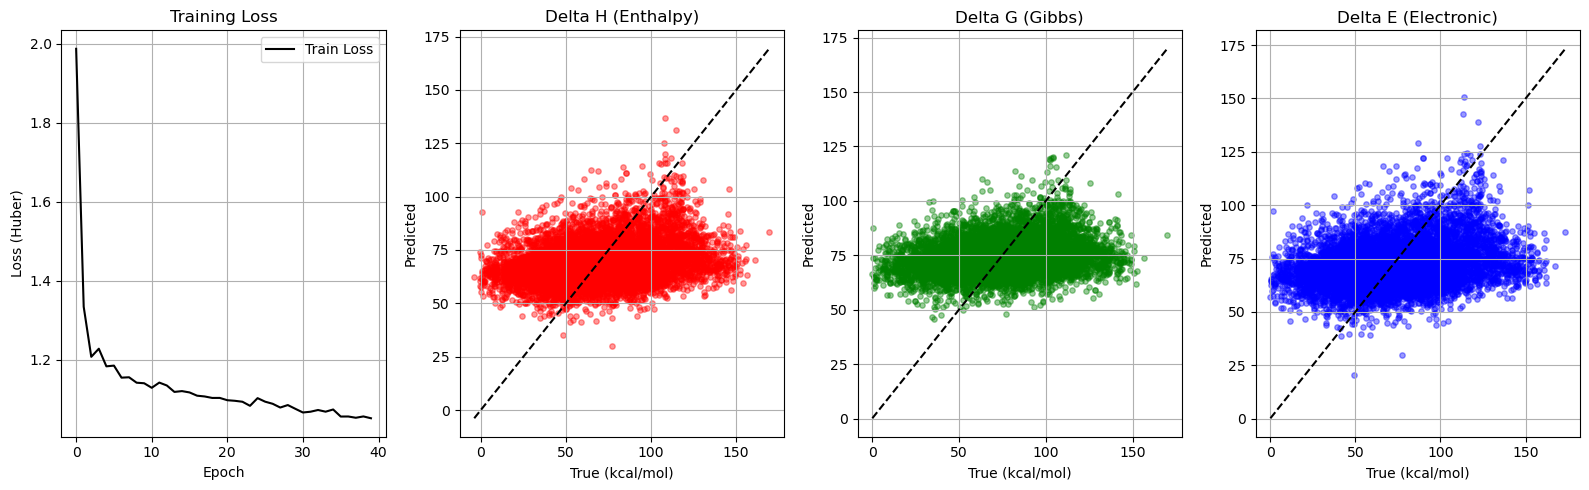

🎉 학습 및 시각화 완료!


In [11]:
if __name__ == "__main__":
    import os
    import matplotlib.pyplot as plt

    # ------------------------------------------------------------------
    # [1] 파일 경로 설정 (여기를 확인하세요)
    # ------------------------------------------------------------------
    # r"..."을 사용하면 윈도우 경로의 백슬래시(\) 오류를 막아줍니다.
    base_dir = r"C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    file_name = "RGD1_CHNO.h5" 
    
    # 경로 합치기
    MY_H5_PATH = os.path.join(base_dir, file_name)
    
    print(f"📂 데이터 파일 경로 확인 중: {MY_H5_PATH}")

    # ------------------------------------------------------------------
    # [2] 파일 존재 여부 확인 및 학습 시작
    # ------------------------------------------------------------------
    if os.path.exists(MY_H5_PATH):
        print("✅ 파일을 찾았습니다! 학습을 시작합니다...")
        
        # limit=2000: 데이터 2000개만 사용하여 테스트 (전체 사용 시 limit=None)
        # epochs=30: 30번 반복 학습
        result = train(MY_H5_PATH, epochs=40, limit=10000)
        
        # ------------------------------------------------------------------
        # [3] 결과 시각화
        # ------------------------------------------------------------------
        if result is not None:
            # 결과 풀기 (Unpacking)
            hist, r_E3, p_E3 = result
            
            # 그래프 그리기 설정
            plt.figure(figsize=(16, 5))
            
            # (1) Loss 그래프
            plt.subplot(1, 4, 1)
            plt.plot(hist['loss'], 'k-', label='Train Loss')
            plt.title("Training Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss (Huber)")
            plt.legend()
            plt.grid(True)
            
            # (2) 에너지별 예측 결과 (H, G, E)
            titles = ["Delta H (Enthalpy)", "Delta G (Gibbs)", "Delta E (Electronic)"]
            keys = ['H', 'G', 'E']
            colors = ['red', 'green', 'blue']
            
            for i, key in enumerate(keys):
                plt.subplot(1, 4, i+2)
                
                real_vals = r_E3[key]
                pred_vals = p_E3[key]
                
                if len(real_vals) > 0:
                    # 산점도 그리기
                    plt.scatter(real_vals, pred_vals, alpha=0.4, color=colors[i], s=15)
                    
                    # 대각선 (정답 기준선) 그리기
                    all_vals = real_vals + pred_vals # 최대/최소 범위 찾기용
                    if all_vals:
                        mn, mx = min(all_vals), max(all_vals)
                        plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1.5, label='Ideal')
                
                plt.title(titles[i])
                plt.xlabel("True (kcal/mol)")
                plt.ylabel("Predicted")
                plt.grid(True)
            
            plt.tight_layout()
            plt.show()
            print("🎉 학습 및 시각화 완료!")
            
        else:
            print("❌ 학습 과정에서 에러가 발생하여 결과를 반환받지 못했습니다.")
    else:
        print("\n[오류] 파일을 찾을 수 없습니다!")
        print(f"경로: {MY_H5_PATH}")
        print("Tip: 경로에 오타가 없는지, 파일명이 정확한지 확인해주세요.")

In [12]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 21.7205    | 27.2439    | 742.2306   | 0.0665    
Delta G (ΔG)    | 20.8127    | 25.9411    | 672.9408   | 0.0460    
Delta E (ΔE)    | 22.4770    | 28.2601    | 798.6336   | 0.0693    
⭐ Average MAE: 21.6701 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

